In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = "none"
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats.contingency import association
from kneed import KneeLocator
import nimfa 

def plot_kde(V, ax, colour = 'k', label=None, limits=2):
    """
    Plot kernel density estimation contours on given axis.
    
    Parameters:
    V: matrix where columns = variables and rows = samples
    ax: axis to attach the plot to
    colour: color for the contour lines
    label: label for the plot
    limits: limits for the plot area
    """
    from scipy.stats import gaussian_kde

    kernel = gaussian_kde(V.T)
    xmin, ymin, xmax, ymax = np.r_[V.min(axis = 0)-limits, V.max(axis = 0)+limits]
    
    # Perform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    
    ax.contour(xx, yy, f, colors=colour, levels = 1, linewidths = 2, label=label)
    
    return ax

# Load acoustic feature data
all_csvs = glob.glob("C:/Users/akundivi/Desktop/Acoustic_Pipeline_New/VirtualSLP-analytics/Clustering/WavFilesConvertedALL441k/Features/*.csv")
all_results = []
for a in all_csvs:
    a = a.replace("\\", "/")
    fname = a.split("/")[-1].split(".")[0]
    temp_data = pd.read_csv(a, index_col="Unnamed: 0")
    temp_data.index = [fname]
    all_results.append(temp_data)

# GET DATA - acoustics
all_results = pd.concat(all_results, axis=0)
print(len(all_results))

# Remove f3, f4, f5 formant features
drop_cols = [('f3' in c) or ('f4' in c) or ('f5' in c) for c in all_results.columns]
all_results.drop(all_results.columns[drop_cols], axis=1, inplace=True)
all_results.index = [i.replace("-V", "").replace("ALS_", "").split("_")[0] for i in all_results.index]
V = all_results.values.copy()
columns = all_results.columns

# GET DATA - perceptual
perceptual = pd.read_csv("C:/Users/akundivi/Desktop/Acoustic_Pipeline_New/VirtualSLP-analytics/Clustering/Data/perceptual_ratings_final_short.csv")
perceptual.index = perceptual['Participant ID'].values
perceptual.index = [i.replace("-V", "") for i in perceptual.index]
perceptual = perceptual.iloc[:, 1:]

# Remove columns with NaN values and calculated scores
summary_cols = [("calculated" in c) for c in perceptual.columns]
clinical_summaries = perceptual.loc[:, summary_cols]
drop_cols = [any(np.isnan(perceptual[c].values)) or ("calculated" in c) for c in perceptual.columns]
perceptual.drop(perceptual.columns[drop_cols], inplace=True, axis=1)

V = perceptual.values
# Merge all data to compare cluster memberships across groups
all_data = pd.merge(left=perceptual, right=all_results, left_index=True, right_index=True)
first_acoustic = np.where(all_data.columns=="f1")[0][0]

77


In [2]:
all_data

,13. Strained Voice (excess vocal effort/hyperfunction),17. Overall Dysphonia (global estimate of voice quality in speech),19. Loudness Decay (speech becomes increasingly quiet when speaking; typically recovers after taking a breath),"20. Reduced Loudness (overall speaking voice is unusually soft, quiet)","21. Short Phrases (respiratory capacity is not sufficient for speech, leading to reduced number of words per phrase and/or frequent breaths which interrupt speech)",23. Monopitch and/or Monoloudness (speech lacks natural inflection patterns or loudness variation),"24. Excess and Equal Stress (excessive effort/stress placed on most or all syllables, including function words such as 'if' 'the' 'and')",25. Reduced Stress (overall reduced emphasis/energy in speech),26. Overall Dysprosody (global estimate of reduced/impaired prosody and stress patterns),27. Hypernasality (nasal quality related to excess air escape through velopharyngeal port),...,cv_phrase_dur,total_pause_dur,fft_peaks1,fft_peaks2,fft_ampli1,fft_ampli2,nrj_below_boundary,nrj_above_boundary,nrj_3_6,ratio_below_above
MIBD67,3,3,2,2,2,3,2,2,3,3,...,1.887533,15.731519,0.439453,2.294922,0.000370,0.000174,0.004141,0.000278,0.000415,14.906249
TIBD99,0,0,0,1,0,0,0,0,0,0,...,1.372677,13.572063,0.292969,0.878906,0.002935,0.001350,0.026577,0.004973,0.006419,5.344199
TIBD101,1,1,1,1,1,2,0,1,2,1,...,2.331086,8.684263,0.927734,1.660156,0.000345,0.000252,0.006953,0.001311,0.001531,5.304779
TIBD102,1,1,1,1,0,0,0,0,0,0,...,2.542280,6.164898,1.269531,0.634766,0.000948,0.000726,0.012007,0.005502,0.005149,2.182415
TIBD103,0,1,0,1,0,0,0,0,0,0,...,2.082212,7.418776,0.292969,4.443359,0.000228,0.000135,0.003311,0.001819,0.001640,1.820205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TIBD81,0,0,0,0,0,0,0,0,0,0,...,1.069679,3.575873,0.830078,0.097656,0.001826,0.000927,0.024259,0.007979,0.008464,3.040206
TIBD84,4,3,2,4,1,1,0,2,2,0,...,2.231499,16.300408,0.244141,1.757812,0.000726,0.000309,0.008126,0.001310,0.001660,6.204319
TIBD86,2,2,1,2,1,1,0,1,1,0,...,2.454532,4.376961,0.146484,0.830078,0.000337,0.000331,0.006203,0.001785,0.002329,3.476016
TIBD91,0,0,0,0,0,0,0,0,0,0,...,2.336847,6.083628,0.488281,1.708984,0.000640,0.000386,0.010070,0.002714,0.003310,3.710066


In [3]:
# Load demographics data
demographics = pd.read_csv('C:/Users/akundivi/Desktop/Acoustic_Pipeline_New/VirtualSLP-analytics/Clustering/Data/ALSDemographics.csv', index_col='participant_id')
demographics = demographics.loc[~demographics.index.duplicated(keep='first')]
demographics.index = [i.replace("-V", "") for i in demographics.index]
print(demographics.shape)

# Merge all data with demographics by participant ID
demographics = pd.merge(left=all_data, right=demographics, left_index=True, right_index=True)
clinical_dem = pd.merge(left=clinical_summaries, right=demographics, left_index=True, right_index=True)

(98, 114)


In [4]:
clinical_dem['sex_arm3'].value_counts()
clinical_dem = clinical_dem[clinical_dem['ALSIBD Total Score (calculated)'] <= 25]
clinical_dem['onset_type_arm3'].value_counts()

onset_type_arm3
3    23
2    16
1     4
4     1
Name: count, dtype: int64

In [5]:
demographics.columns[:20]

Index(['13. Strained Voice (excess vocal effort/hyperfunction)',
       '17. Overall Dysphonia (global estimate of voice quality in speech)',
       '19. Loudness Decay (speech becomes increasingly quiet when speaking; typically recovers after taking a breath) ',
       '20. Reduced Loudness (overall speaking voice is unusually soft, quiet)',
       '21. Short Phrases (respiratory capacity is not sufficient for speech, leading to reduced number of words per phrase and/or frequent breaths which interrupt speech)  ',
       '23. Monopitch and/or Monoloudness (speech lacks natural inflection patterns or loudness variation)',
       '24. Excess and Equal Stress (excessive effort/stress placed on most or all syllables, including function words such as 'if' 'the' 'and')',
       '25. Reduced Stress (overall reduced emphasis/energy in speech)',
       '26. Overall Dysprosody (global estimate of reduced/impaired prosody and stress patterns) ',
       '27. Hypernasality (nasal quality related t

In [6]:
# Filter demographics for ALSIBD score > 25
demographics = demographics[demographics['alsibd_total_score_v3_v3'] > 25]

In [7]:
col = 'age_years'
col = 'sex_arm3'
col = 'alsfrs_total_score_r_arm3'
col = 'bulbar_score_r_arm3'
col = 'alsibd_sit_intell'
col = 'alsibd_spr'
cols_to_check = ['age_years', 'sex_arm3', 'alsfrs_total_score_r_arm3', 'bulbar_score_r_arm3', 'alsibd_sit_intell', 'alsibd_spr', 'alsibd_total_score_v3_v3']
for col in cols_to_check:
    print(col)
    print(demographics[col].median())
    print(np.subtract(*np.nanpercentile(demographics[col], [75, 25])))
    print('\n\n')

age_years
67.5
11.25



sex_arm3
2.0
1.0



alsfrs_total_score_r_arm3
33.5
9.25



bulbar_score_r_arm3
7.0
3.25



alsibd_sit_intell
86.815
35.682500000000005



alsibd_spr
91.73
51.03750000000001



alsibd_total_score_v3_v3
41.0
20.25





Acoustic Mode
(76, 37)

Optimal components = 4


Optimal components = 4



C:\Users\akundivi\AppData\Local\Temp\ipykernel_26216\705113500.py:64: RuntimeWarning: divide by zero encountered in divide
  check = rss*100/V.T
C:\Users\akundivi\AppData\Local\Temp\ipykernel_26216\1485497137.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, f, colors=colour, levels = 1, linewidths = 2, label=label)


% of original value =  [[1.71986899e-02 1.00051380e-01 4.74282714e-01 ... 2.71379694e-01
  1.55111007e-01 3.85669033e+00]
 [6.40977145e+00 8.52546510e-01 8.06186798e+00 ... 5.69883378e+00
  9.73830007e-01 2.39650010e+01]
 [1.85025668e-01            inf 1.87728218e+01 ... 3.45972185e-04
  4.41630865e-01 5.52588364e+00]
 ...
 [1.24612688e+01 1.36701378e+00 1.33648100e+00 ... 4.20976987e+00
  3.48913953e+00 7.74561138e+00]
 [7.44764540e+00 3.22978441e+00 2.28946827e+00 ... 7.18854392e+00
  2.18011746e+00 5.60457256e+00]
 [2.50636249e-01 2.24202946e+01 8.06409132e+01 ... 1.41099680e+02
  4.81080309e+01 1.02248355e+01]]
Residual sum of squares (RSS) = [[8.67570420e-05 5.89830602e-04 3.22854604e-03 ... 1.62884890e-03
  8.59965421e-04 2.48018544e-02]
 [2.20099013e-02 7.02637603e-03 7.71436667e-02 ... 4.40284771e-02
  6.69465828e-03 6.74571707e-02]
 [1.17456974e-03 6.08669411e-02 3.34937695e-02 ... 1.75726161e-06
  1.56912762e-03 2.59542249e-02]
 ...
 [3.26159423e-03 6.42497135e-03 1.65465017e

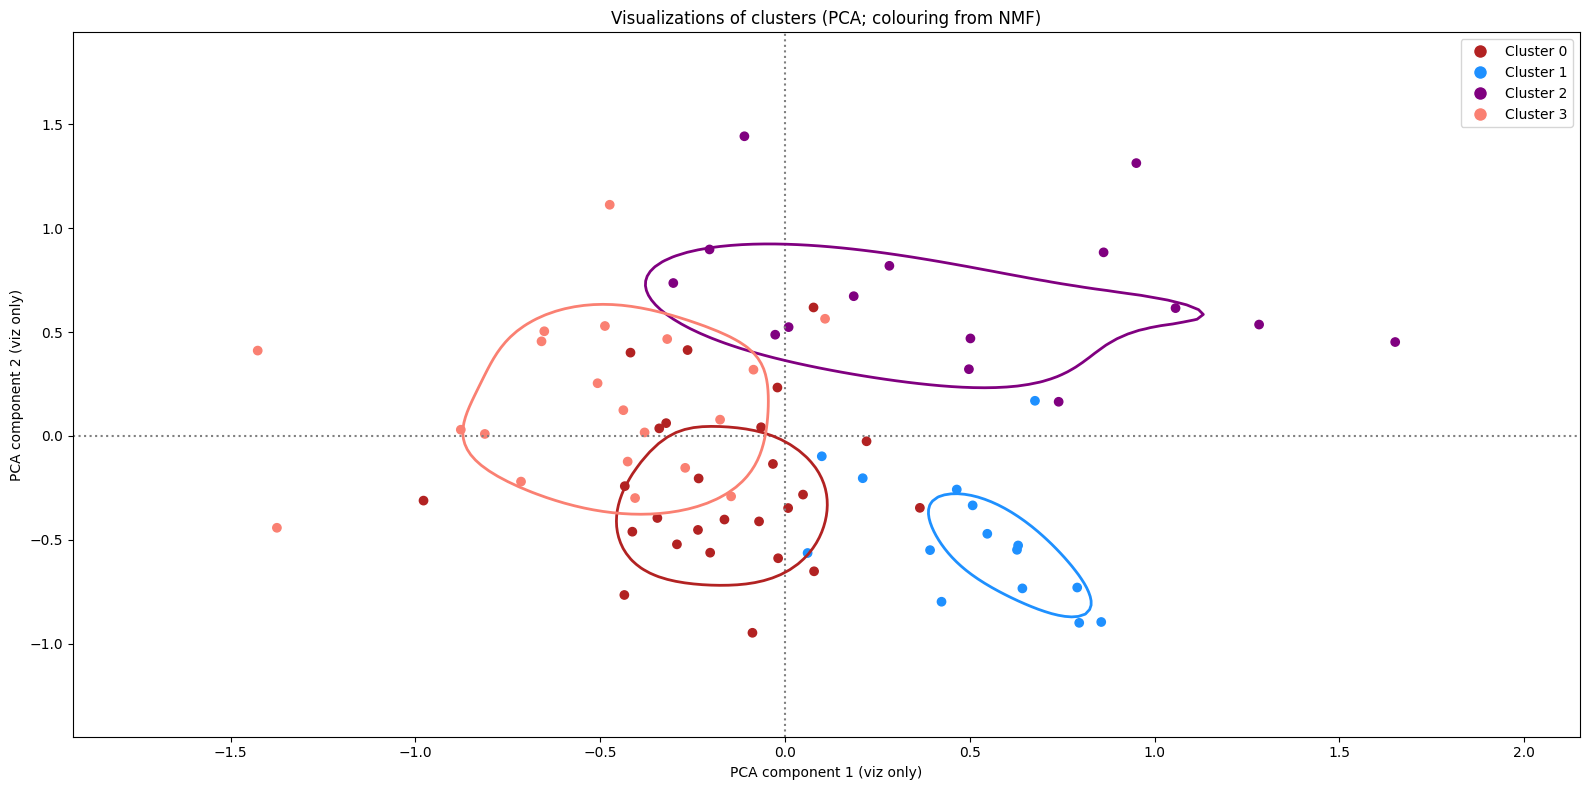

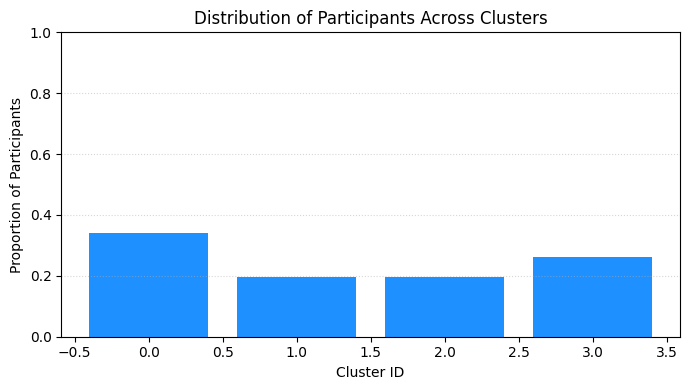

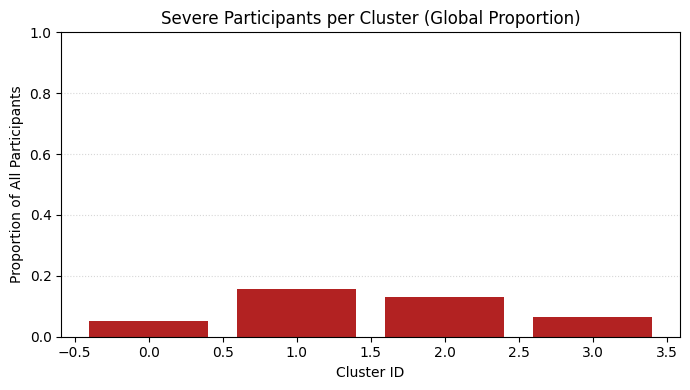

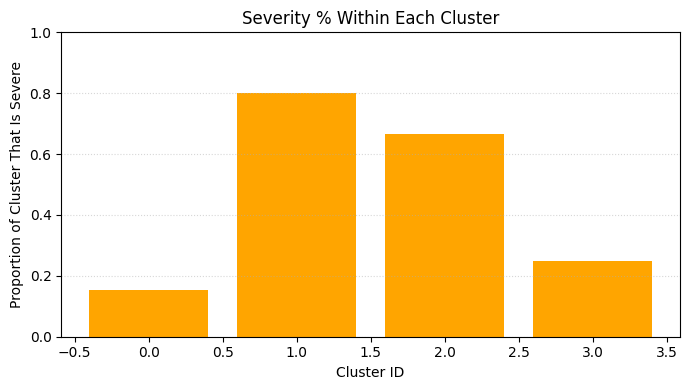

Perceptual Mode
(76, 13)

Optimal components = 4

% of original value =  [[2.80861618e-01            inf 1.07357917e-02 6.18270535e-04
             inf            inf            inf            inf
             inf 1.10675716e-01            inf            inf
  1.65132447e+00 3.95971521e-01            inf            inf
             inf            inf 1.09448868e-01            inf
             inf            inf 3.07500286e-03 2.89269963e-03
             inf            inf            inf 5.43310147e+00
  2.63739647e+00 3.02108094e+00            inf 1.92213230e+00
             inf 1.04296235e+00            inf            inf
  1.36756935e+00 1.54009436e-01            inf            inf
  7.67900203e-01            inf 1.10240973e+00 2.12422237e+00
             inf            inf            inf            inf
  5.63851449e+00 5.49124805e-01 1.61191704e+01            inf
             inf            inf 4.21359532e-02            inf
             inf 8.99633587e-01            inf            i

C:\Users\akundivi\AppData\Local\Temp\ipykernel_26216\705113500.py:64: RuntimeWarning: divide by zero encountered in divide
  check = rss*100/V.T
C:\Users\akundivi\AppData\Local\Temp\ipykernel_26216\1485497137.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx, yy, f, colors=colour, levels = 1, linewidths = 2, label=label)


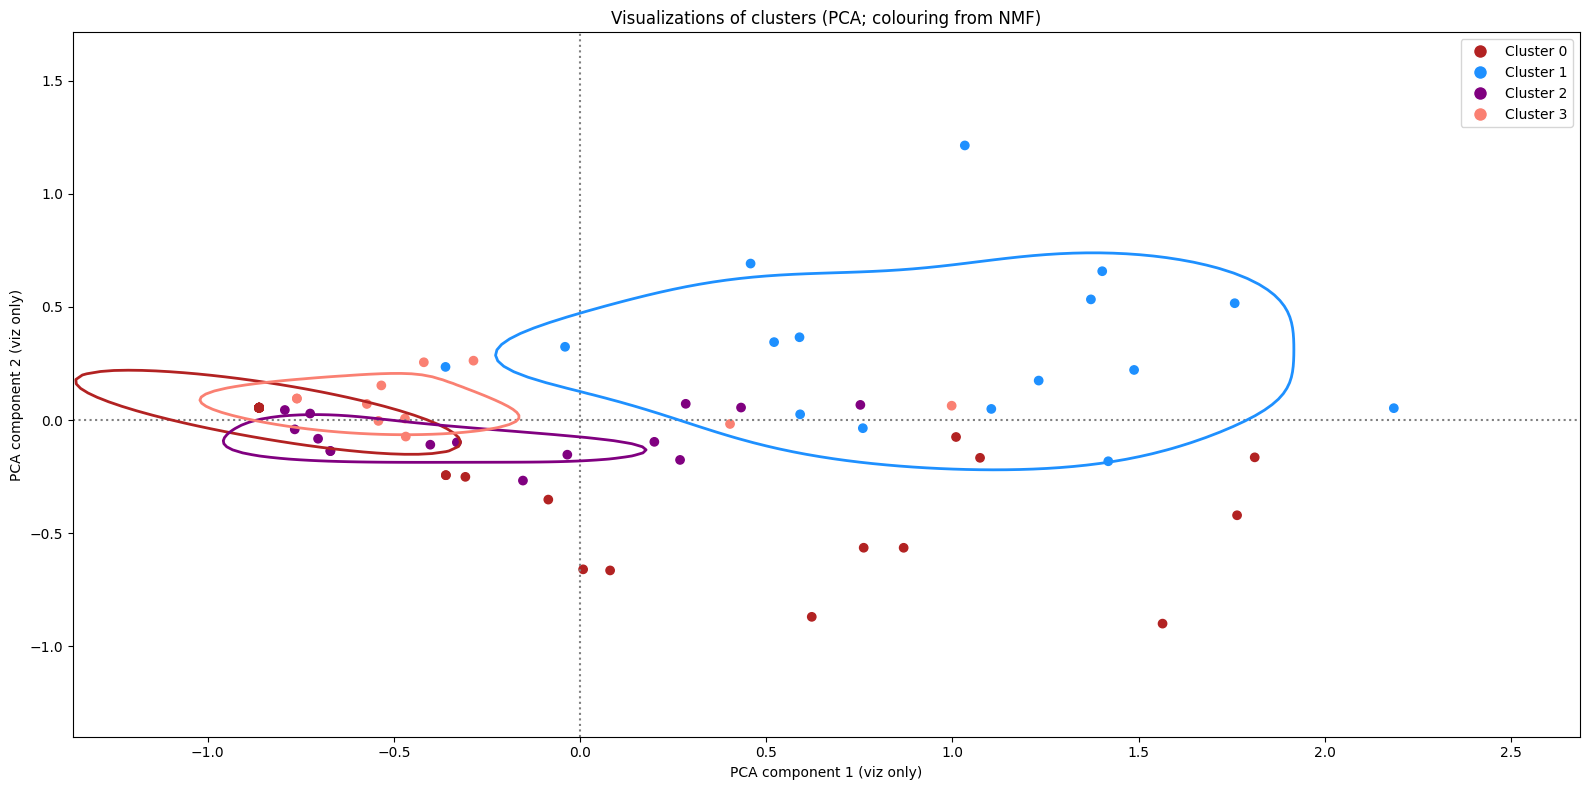

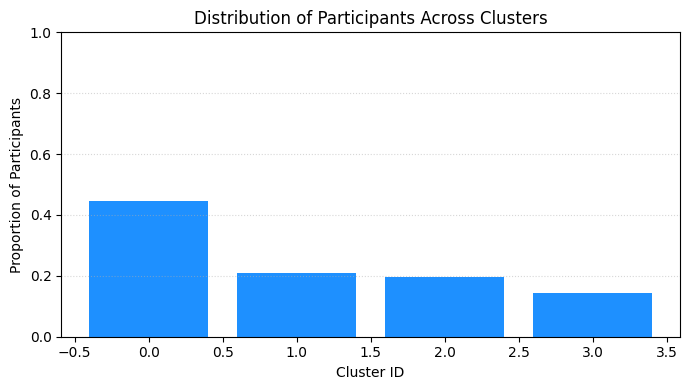

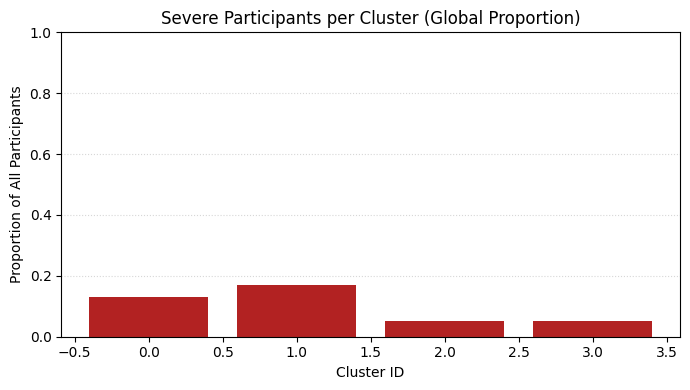

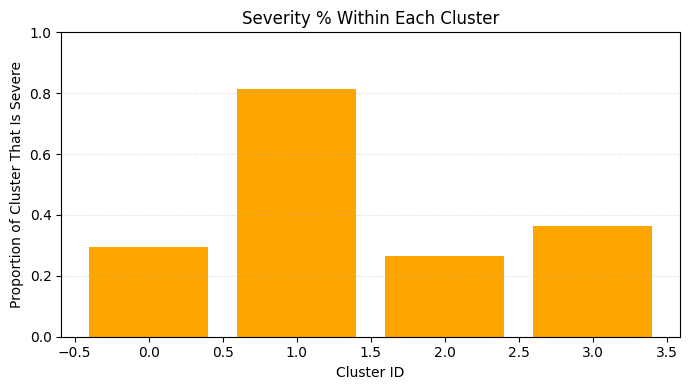

In [8]:
all_clusters = {}
all_feature_maps = {}
coef_dists = {}
basis_dists = {}

for type in ["acoustic", "perceptual"]:

    if type=="acoustic":
        print("Acoustic Mode")
        V = all_data.iloc[:, first_acoustic:]
        columns = all_data.columns[first_acoustic:]
    elif type=="perceptual":
        print("Perceptual Mode")
        V = all_data.iloc[:, :first_acoustic]
        columns = all_data.columns[:first_acoustic]
        
    # Ensure clinical summaries match all_data individuals and row order
    clinical_summaries = clinical_summaries.loc[[i in all_data.index for i in clinical_summaries.index], :]
    print(V.shape)
    
    # Rescale data for NMF (enforce positivity and uniform scale)
    mms = MinMaxScaler()
    V = mms.fit_transform(V)
    m, n = V.shape

    # NMF with NIMFA
    from nimfa.methods import seeding
    np.random.seed(1)  # For reproducibility

    # Define search range for NMF components
    ranks = np.arange(2, 8)
    results = {}

    for rank in ranks:
        nmf = nimfa.Nmf(V.T, rank=rank, max_iter=10000, seed="nndsvd")
        fit = nmf()
        
        # Calculate quality measures
        rss = fit.fit.rss()  # Residual Sum of Squares
        evar = fit.fit.evar()  # Explained variance
        
        results[rank] = {
            'rss': rss,
            'evar': evar,
        }

    # Generate vector of error values
    errors = [results[r]['rss'] for r in ranks]

    # Use Kneedle algorithm to identify optimal number of components
    kneedle = KneeLocator(x=ranks, y=errors, S=0.0, curve="convex", direction="decreasing")
    optimal_components = kneedle.knee
    print(f"\nOptimal components = {optimal_components}\n")

    # Re-fit using optimal number of components
    nmf = nimfa.Nmf(V.T, rank=optimal_components, max_iter=10000, seed="nndsvd")
    fit = nmf()
    basis = fit.fit.basis()  # features
    coef = fit.fit.coef()  # individual clusters

    # Validate NMF fit by comparing reconstruction to original data
    V_hat = np.dot(basis, coef)
    rss = np.power((V.T - V_hat), 2)
    check = rss*100/V.T
    print("% of original value = ", check) 
    print(f"Residual sum of squares (RSS) = {rss}")

    # Map basis and coefficient matrices to feature weights and cluster indices
    features = np.array(np.argmax(basis, axis=1))
    features_df = pd.DataFrame(data=features, index=columns)
    features_df.to_csv(f"C:/Users/akundivi/Desktop/Acoustic_Pipeline_New/VirtualSLP-analytics/Clustering/feature_weights_{type}.csv")
    clusters = np.array(np.argmax(coef, axis=0))

    coef_dist = np.exp(coef)/np.sum(np.exp(coef), axis=0)
    coef_dists[type] = coef_dist
    basis_dists[type] = basis

    # Plotting parameters
    alsibd_thresh = 25
    lim = 0.5  # Visual scale of KDE plot
    mapping = {0: "firebrick", 1: "dodgerblue", 2: "purple", 3: "salmon", 4: "goldenrod", 5: "forestgreen"}
    vectorized_func = np.vectorize(lambda x: mapping[x])
    string_array = vectorized_func(clusters)

    # Plot the clustering with PCA visualization
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    pca = PCA(n_components=2)
    pca_out = pca.fit_transform(V)
    ax.axvline(0, c="grey", ls=":")
    ax.axhline(0, c="grey", ls=":")
    ax.scatter(pca_out[:, 0], pca_out[:, 1], c = string_array[0])

    # Add KDE contours for each cluster
    for c in np.unique(clusters[0]):
        plot_kde(pca_out[clusters[0]==c, :], ax=ax, colour = mapping[c], label=None, limits=lim)

    ax.set_xlabel('PCA component 1 (viz only)')
    ax.set_ylabel('PCA component 2 (viz only)')
    ax.set_title('Visualizations of clusters (PCA; colouring from NMF)')

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=mapping[c], markersize=10, label=f"Cluster {c}")
           for c in np.unique(clusters[0])]
    ax.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    plt.show()

    # Compute cluster statistics
    from collections import Counter
    counts = Counter(clusters[0])
    categories = list(counts.keys())
    values = list(counts.values())

    # Compute counts of severe participants per cluster
    ALSIBD_thresh = 25
    severe_mask = clinical_summaries["ALSIBD Total Score (calculated)"] > ALSIBD_thresh
    severe_clusters = clusters[0][severe_mask]
    counts_severe = Counter(severe_clusters)
    categories_severe = list(counts_severe.keys())
    values_severe = list(counts_severe.values())

    # Bar plot 1: Cluster size distribution
    plt.figure(figsize=(7, 4))
    plt.bar(categories, np.array(values) / len(clusters[0]), color='dodgerblue')
    plt.xlabel("Cluster ID")
    plt.ylabel("Proportion of Participants")
    plt.title("Distribution of Participants Across Clusters")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Bar plot 2: Severe participants per cluster (global proportion)
    plt.figure(figsize=(7, 4))
    plt.bar(categories_severe, np.array(values_severe) / len(clusters[0]), color='firebrick')
    plt.xlabel("Cluster ID")
    plt.ylabel("Proportion of All Participants")
    plt.title("Severe Participants per Cluster (Global Proportion)")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Bar plot 3: Severity ratio within each cluster
    within_cluster_ratios = np.array(values_severe) / np.array([counts[c] for c in categories_severe])
    plt.figure(figsize=(7, 4))
    plt.bar(categories_severe, within_cluster_ratios, color='orange')
    plt.xlabel("Cluster ID")
    plt.ylabel("Proportion of Cluster That Is Severe")
    plt.title("Severity % Within Each Cluster")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # Store cluster results
    if type=="perceptual":
        perceptual_clusters = clusters.copy()
        perceptual_clusters_df = pd.DataFrame(data = perceptual_clusters[0], index = all_data.index)
    elif type=="acoustic":
        acoustic_clusters = clusters.copy()
        acoustic_clusters_df = pd.DataFrame(data = acoustic_clusters[0], index = all_data.index)
    
    all_clusters[type] = clusters
    all_feature_maps[type] = features_df

In [9]:
import pandas as pd

# Extract top features for each cluster
top_feats = {}
for type in ["acoustic", "perceptual"]:
    print(f"\nTop features for {type} data:")
    basis = basis_dists[type]
    if type == "acoustic":
        columns = all_data.columns[first_acoustic:]
    elif type == "perceptual":
        columns = all_data.columns[:first_acoustic]

    basis_df = pd.DataFrame(basis, index=columns)
    top_n = 5  # Number of top features to extract
    top_features_per_cluster = {}

    print("\nTop features per cluster:")
    for cluster_idx in range(basis_df.shape[1]):
        # Sort features by importance in descending order
        top_features = basis_df.iloc[:, cluster_idx].nlargest(top_n)
        
        # Store in dictionary
        top_features_per_cluster[cluster_idx] = {
            "Feature Names": list(top_features.index),
            "Scores": list(top_features.values)
        }
        
        # Display feature names and scores
        print(f"\nCluster {cluster_idx}:")
        for feature, score in zip(top_features.index, top_features.values):
            print(f"{feature}: {score}")
    
    top_feats[type] = top_features_per_cluster
    print("\n\n")


Top features for acoustic data:

Top features per cluster:

Cluster 0:
speech_rate: 1.1990798389046686
f2_d_dx_prc_5: 1.1393426133866362
f2: 1.0682879401068257
f1_d_dx_prc_5: 1.0558814075865346
intensity_CV: 1.0340475431159903

Cluster 1:
f2_d_dx_prc_5: 1.1175339508521793
f1_d_dx_prc_5: 1.0233057681031819
percent_pause: 0.9815047795048819
f2: 0.8746577188437334
total_pause_dur: 0.8712054768301933

Cluster 2:
f0_mean: 1.2493627044507292
f0_std: 0.9180531074431612
CPP_mean: 0.8996132192901624
f1_bw: 0.7751456296809079
f2_d_dx_prc_5_95: 0.7677242581947245

Cluster 3:
f1_d_dx_prc_5_95: 0.851826602702183
CPP_F1_comp: 0.8269187099155056
f1_d_dx_prc_95: 0.776317260290671
f2_d_dx_prc_5_95: 0.743666239216836
f2_d_dx_prc_95: 0.7033981567646274




Top features for perceptual data:

Top features per cluster:

Cluster 0:
30. Reduced Overall Speaking Rate (based on total duration of passage reading, including articulation rate and pauses): 1.2356673017875206
23. Monopitch and/or Monoloudness (spee

In [10]:
coef.shape

(4, 76)

C:\Users\akundivi\AppData\Local\Temp\ipykernel_26216\3059995497.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', basis_df.shape[0])


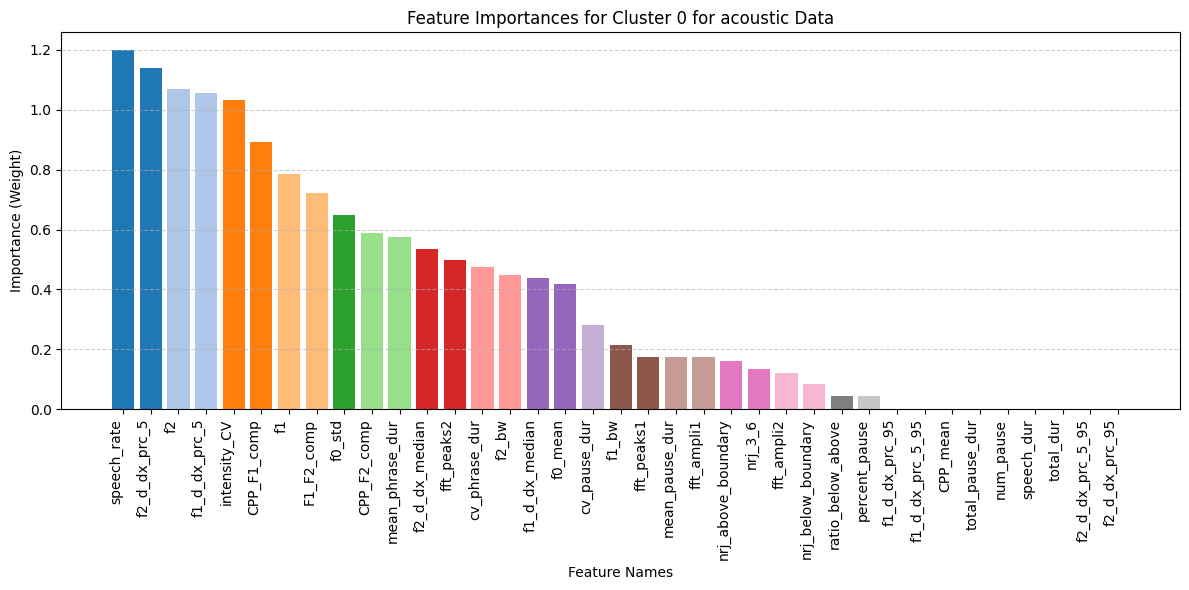

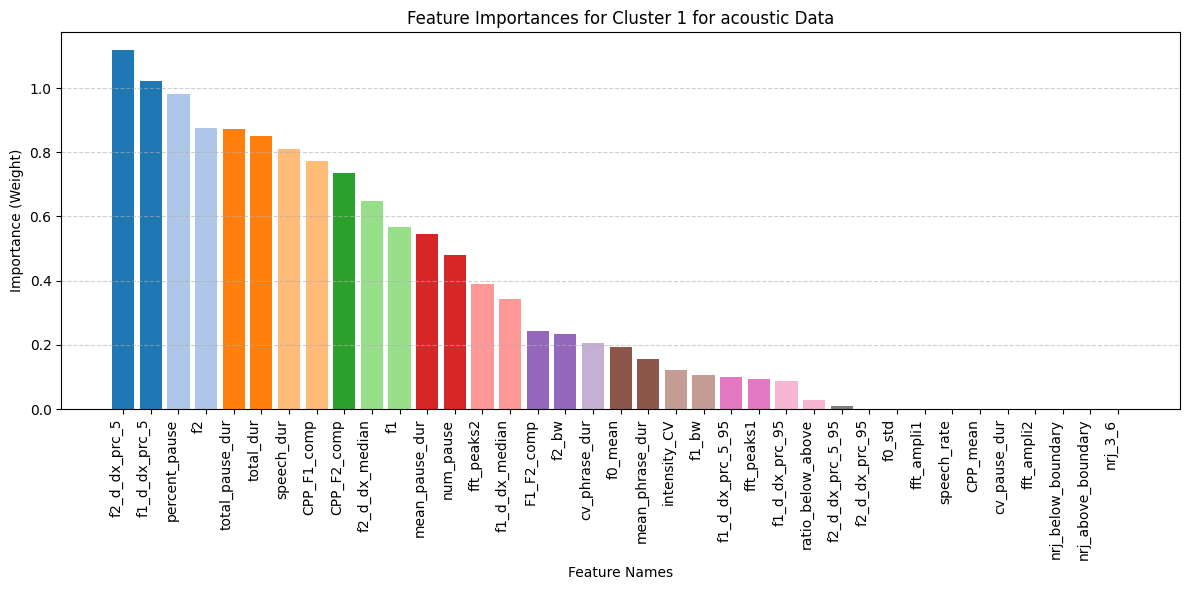

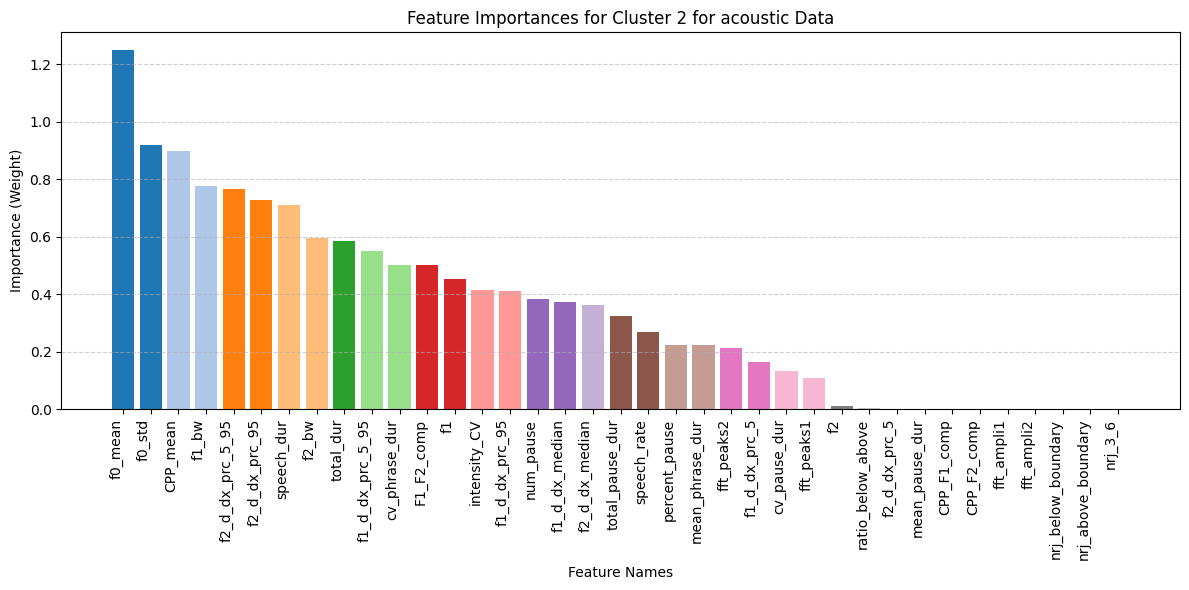

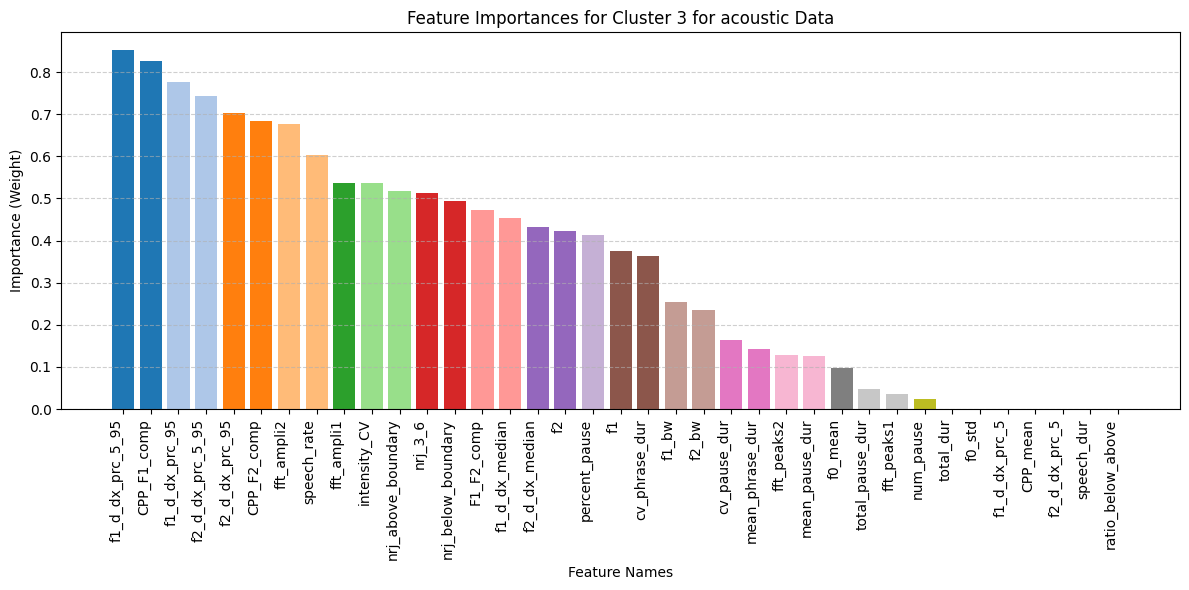

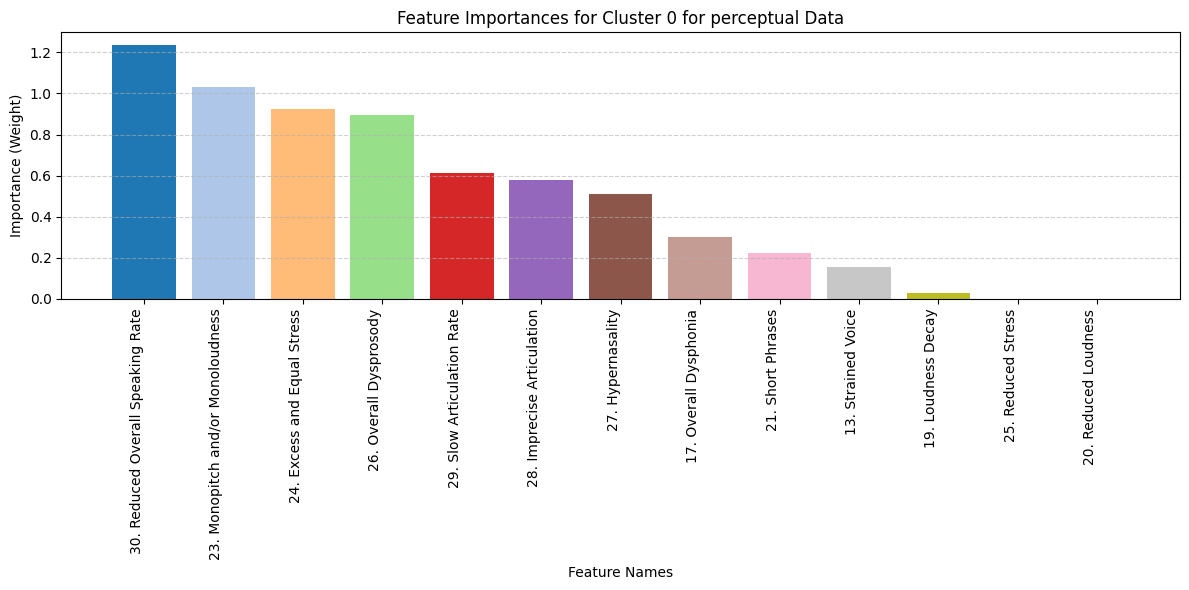

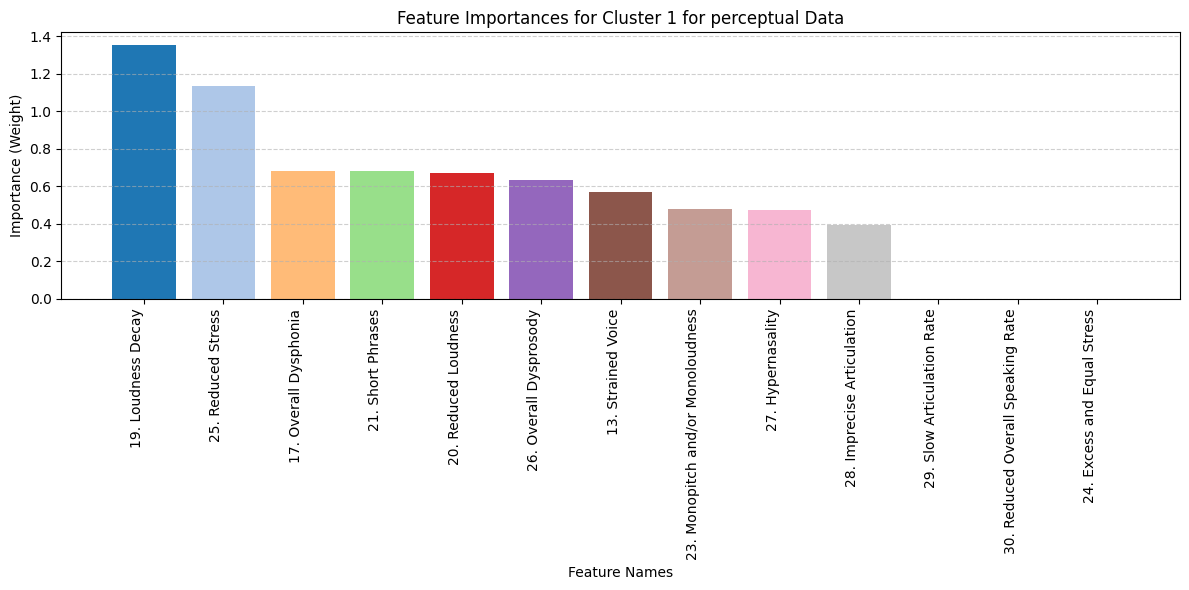

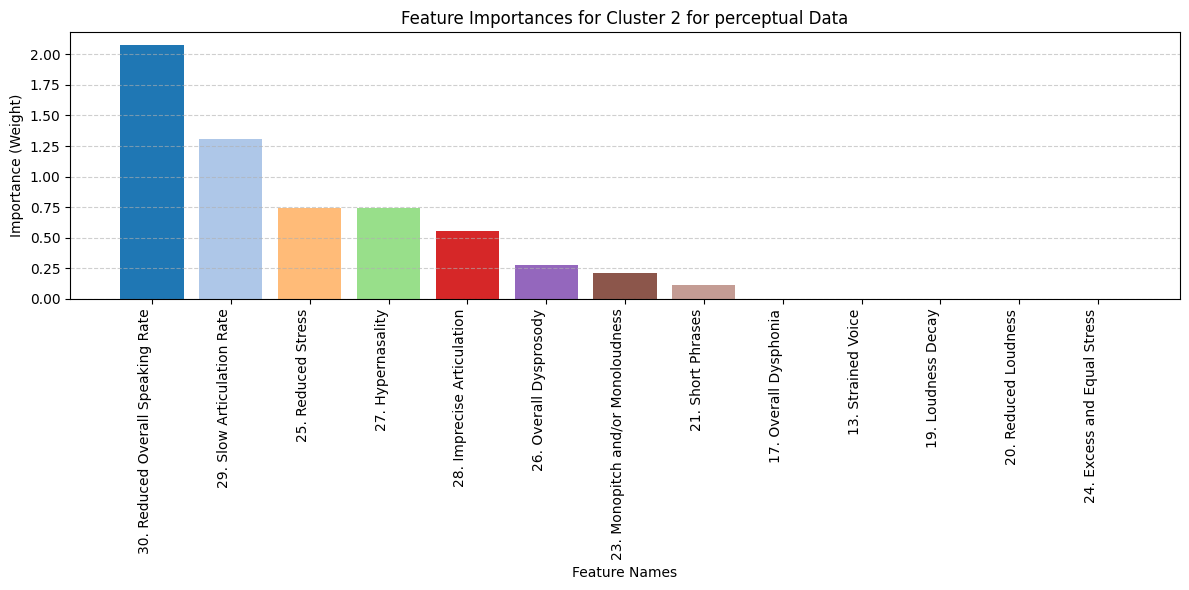

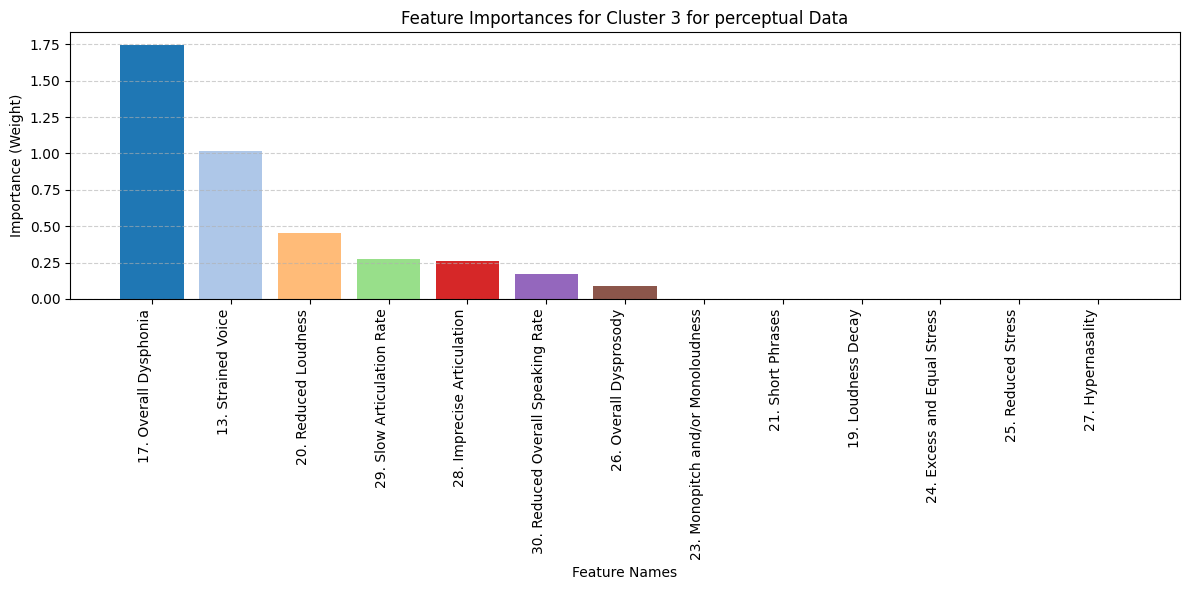

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import re

for type in ["acoustic", "perceptual"]:
    basis = basis_dists[type]
    if type == "acoustic":
        columns = all_data.columns[first_acoustic:]
    elif type == "perceptual":
        columns = all_data.columns[:first_acoustic]

    # Create DataFrame with proper indexing
    basis_df = pd.DataFrame(basis, index=columns)

    # Plotting parameters
    figsize = (12, 6)
    color_palette = plt.cm.get_cmap('tab20', basis_df.shape[0])

    # Create bar plots for each cluster
    for cluster_idx in range(basis_df.shape[1]):
        plt.figure(figsize=figsize)
        
        # Sort features by importance for current cluster
        all_features = basis_df.iloc[:, cluster_idx].sort_values(ascending=False)
        feature_names = all_features.index
        
        # Clean perceptual feature names by removing parenthetical content
        if type == "perceptual":
            feature_names = [re.sub(r"\(.*\)", "", feat).strip() for feat in all_features.index]
        
        # Plot
        plt.bar(feature_names, all_features.values, color=[color_palette(i) for i in range(len(all_features))])
        plt.title(f"Feature Importances for Cluster {cluster_idx} for {type} Data")
        plt.xlabel("Feature Names")
        plt.ylabel("Importance (Weight)")
        plt.xticks(rotation=90, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

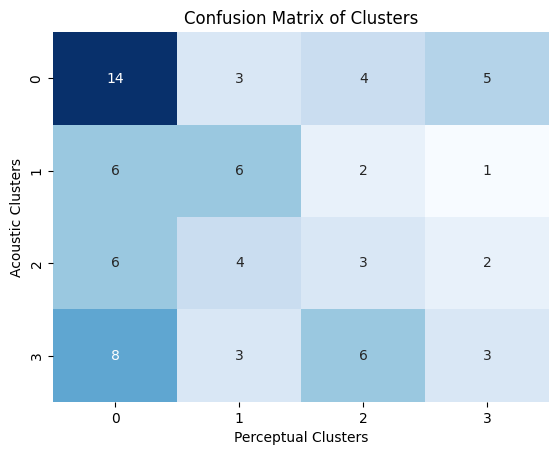

Cramer's V: 0.18336483136090825

--- PERCEPTUAL MODE ---


{0: ['Monopitchand/orMonoloudness',
  'ExcessandEqualStress',
  'OverallDysprosody',
  'ImpreciseArticulation'],
 1: ['LoudnessDecay', 'ReducedLoudness', 'ShortPhrases', 'ReducedStress'],
 2: ['Hypernasality', 'SlowArticulationRate', 'ReducedOverallSpeakingRate'],
 3: ['StrainedVoice', 'OverallDysphonia']}

1
Med: 3.0
Q1: 1.0
Q3: 29.0


2
Med: 42.5
Q1: 32.5
Q3: 48.75


3
Med: 12.0
Q1: 9.0
Q3: 24.5


4
Med: 18.0
Q1: 10.0
Q3: 26.0



--- ACOUSTIC MODE ---


{0: ['f1',
  'f2',
  'f1_d_dx_prc_5',
  'f2_d_dx_prc_5',
  'CPP_F1_comp',
  'F1_F2_comp',
  'intensity_CV',
  'speech_rate',
  'mean_phrase_dur',
  'cv_pause_dur',
  'fft_peaks1',
  'fft_peaks2',
  'ratio_below_above'],
 1: ['f2_d_dx_median',
  'CPP_F2_comp',
  'total_dur',
  'speech_dur',
  'percent_pause',
  'num_pause',
  'mean_pause_dur',
  'total_pause_dur'],
 2: ['f1_bw',
  'f2_bw',
  'f2_d_dx_prc_95',
  'f2_d_dx_prc_5_95',
  'f0_mean',
  'f0_std',
  'CPP_mean',
  'cv_phrase_dur'],
 3: ['f1_d_dx_median',
  'f1_d_dx_prc_95',
  'f1_d_dx_prc_5_95',
  'fft_ampli1',
  'fft_ampli2',
  'nrj_below_boundary',
  'nrj_above_boundary',
  'nrj_3_6']}

1
Med: 10.5
Q1: 0.25
Q3: 17.75


2
Med: 44.0
Q1: 32.5
Q3: 51.0


3
Med: 36.0
Q1: 11.0
Q3: 59.0


4
Med: 5.0
Q1: 2.0
Q3: 17.0




In [12]:
import seaborn as sns

if ('perceptual_clusters_df' in locals()) and ('acoustic_clusters_df' in locals()):
    catted = pd.concat([perceptual_clusters_df, acoustic_clusters_df], axis=1)
    catted.columns = ['perceptual', "acoustic"]

    observed = confusion_matrix(catted['acoustic'], catted['perceptual'])

    # Plot confusion matrix
    sns.heatmap(observed, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(catted['perceptual']), 
                yticklabels=np.unique(catted['acoustic']))
    plt.xlabel("Perceptual Clusters")
    plt.ylabel("Acoustic Clusters")
    plt.title("Confusion Matrix of Clusters")
    plt.show()
    
    # Calculate Cramer's V for association strength
    cramers_v = association(observed[:4, :], method = "cramer")
    print(f"Cramer's V: {cramers_v}")

# Map features to clusters for each mode
cluster_feature_mappings = {}
for mode in ["perceptual","acoustic"]:
    print(f"\n--- {mode.upper()} MODE ---")
    clusters = all_clusters[mode]
    features_df = all_feature_maps[mode]

    cluster_feature_mapping = {}
    for ct in np.unique(clusters[0]):
        catted.index[catted[mode]==ct]
        cluster_feature_mapping.update({ct: list(features_df.index[features_df.values.ravel()==ct])})
        if mode=="perceptual":
            cluster_feature_mapping.update({ct: [i.replace("  ", "(").replace(":", "(").split(". ")[1].split("(")[0].replace(" ", "") for i in list(features_df.index[features_df.values.ravel()==ct])]})

    cluster_feature_mappings[mode] = cluster_feature_mapping
    display(cluster_feature_mapping)
    
    # Calculate severity statistics per cluster
    for cluster_idx in np.unique(clusters[0]):
        cluster_severities = clinical_summaries.loc[:, "ALSIBD Total Score (calculated)"].loc[catted[mode]==cluster_idx]
        
        print(cluster_idx+1)
        print("Med:", np.median(cluster_severities.values))
        print("Q1:", np.quantile(cluster_severities.values, 0.25))
        print("Q3:", np.quantile(cluster_severities.values, 0.75))
        print("\n")

In [13]:
# Calculate confusion matrix accuracy metrics
print("Accuracy (trace/sum):", np.trace(observed)/np.sum(observed))
print("Total observations:", np.sum(observed))

Accuracy (trace/sum): 0.34210526315789475
Total observations: 76


In [14]:
coef.shape

(4, 76)

In [15]:
probs_acoustic = coef_dists["acoustic"].T
print(probs_acoustic.shape)
probs_perceptual = coef_dists["perceptual"].T
print(probs_perceptual.shape)
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import jensenshannon
import numpy as np

# Compute average probability distribution per cluster
def average_distributions(distributions, assignments, n_clusters):
    assignments = np.asarray(assignments).flatten()
    avg = []
    for k in range(n_clusters):
        avg.append(np.mean(distributions[assignments == k], axis=0))
    return np.squeeze(np.array(avg))

# Hard assignments
acoustic_labels = np.argmax(probs_acoustic, axis=1).reshape(-1)
perceptual_labels = np.argmax(probs_perceptual, axis=1).reshape(-1)

n_clusters = probs_acoustic.shape[1]

# Get average distributions per cluster_feature_mapping
acoustic_avg = average_distributions(probs_acoustic, acoustic_labels, n_clusters)

perceptual_avg = average_distributions(probs_perceptual, perceptual_labels, n_clusters)

print(acoustic_avg.shape)
print(perceptual_avg.shape)
# Build cost matrix of JS divergence
cost_matrix = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        cost_matrix[i, j] = jensenshannon(acoustic_avg[i], perceptual_avg[j])**2

# Solve optimal assignment
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create label mapping
acoustic_to_perceptual = dict(zip(row_ind, col_ind))


(76, 4)
(76, 4)
(4, 4)
(4, 4)


In [16]:
acoustic_avg

array([[0.30790342, 0.23485795, 0.22501995, 0.23221868],
       [0.21903022, 0.32907242, 0.22417478, 0.22772258],
       [0.23189683, 0.2210495 , 0.32356491, 0.22348876],
       [0.23687685, 0.21993799, 0.21532007, 0.3278651 ]])

In [17]:
cost_matrix

array([[0.00042995, 0.00630489, 0.004323  , 0.0047865 ],
       [0.00518481, 0.00029106, 0.00513662, 0.00596069],
       [0.00531401, 0.00721362, 0.00122826, 0.00444464],
       [0.00481191, 0.01007926, 0.00552972, 0.00152657]])

In [18]:
acoustic_to_perceptual

{0: 0, 1: 1, 2: 2, 3: 3}

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 6: Permute acoustic probs to match perceptual clusters ---
# Build reverse mapping: perceptual index → acoustic index
perm = [k for k, v in sorted(acoustic_to_perceptual.items(), key=lambda x: x[1])]

probs_acoustic_aligned = probs_acoustic[:, perm]  # same shape, aligned dimensions


# --- Step 7: Compute similarity metrics per patient ---
# JS Divergence (symmetrized and squared for interpretability)
js_divs = [jensenshannon(np.array(a)[0], np.array(p)[0], base=2)**2
           for a, p in zip(probs_acoustic_aligned, probs_perceptual)]

# Cosine similarity
cos_sims = [cosine_similarity(np.asarray(a).reshape(1, -1), np.asarray(p).reshape(1, -1))[0, 0]
            for a, p in zip(probs_acoustic_aligned, probs_perceptual)]

# --- Step 8: Print summary stats ---
print("Mean JS divergence:", np.mean(js_divs))
print("Mean cosine similarity:", np.mean(cos_sims))

Mean JS divergence: 0.010452297393388696
Mean cosine similarity: 0.9711809375452235


In [20]:
import numpy as np

# --- Step 7: Compute Bhattacharyya Coefficient per patient ---
def bhattacharyya_coefficient(p, q):
    """
    Computes the Bhattacharyya coefficient between two distributions.
    Parameters:
    - p: First probability distribution (1D numpy array).
    - q: Second probability distribution (1D numpy array).
    Returns:
    - Bhattacharyya coefficient (float).
    """
    return np.sum(np.sqrt(p * q))

# Calculate Bhattacharyya Coefficient for each patient
bhatt_coeffs = [bhattacharyya_coefficient(np.array(a).squeeze(), np.array(p).squeeze()) 
                for a, p in zip(probs_acoustic_aligned, probs_perceptual)]

# Convert to numpy array for analysis
bhatt_coeffs = np.array(bhatt_coeffs)

# Display summary statistics
print("Mean Bhattacharyya Coefficient:", np.mean(bhatt_coeffs))
print("Standard Deviation:", np.std(bhatt_coeffs))


Mean Bhattacharyya Coefficient: 0.9927261863875295
Standard Deviation: 0.007606391557023795


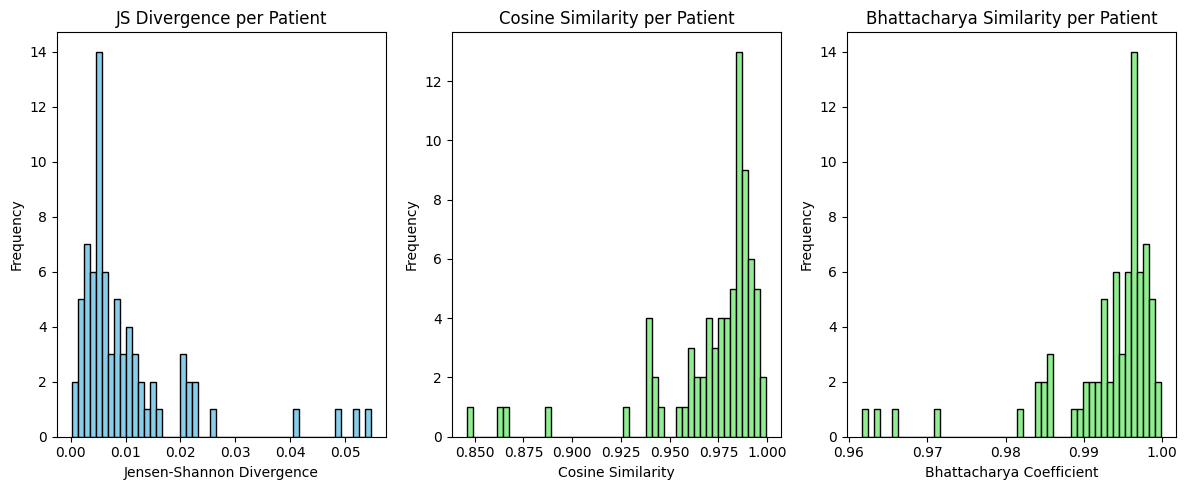

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
js_divs = np.array(js_divs).flatten()
cos_sims = np.array(cos_sims).flatten()
plt.subplot(1, 3, 1)
plt.hist(js_divs, bins=50, color='skyblue', edgecolor='black')
plt.title("JS Divergence per Patient")
plt.xlabel("Jensen-Shannon Divergence")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(cos_sims, bins=50, color='lightgreen', edgecolor='black')
plt.title("Cosine Similarity per Patient")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(bhatt_coeffs, bins=50, color='lightgreen', edgecolor='black')
plt.title("Bhattacharya Similarity per Patient")
plt.xlabel("Bhattacharya Coefficient")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



Top features for acoustic data:


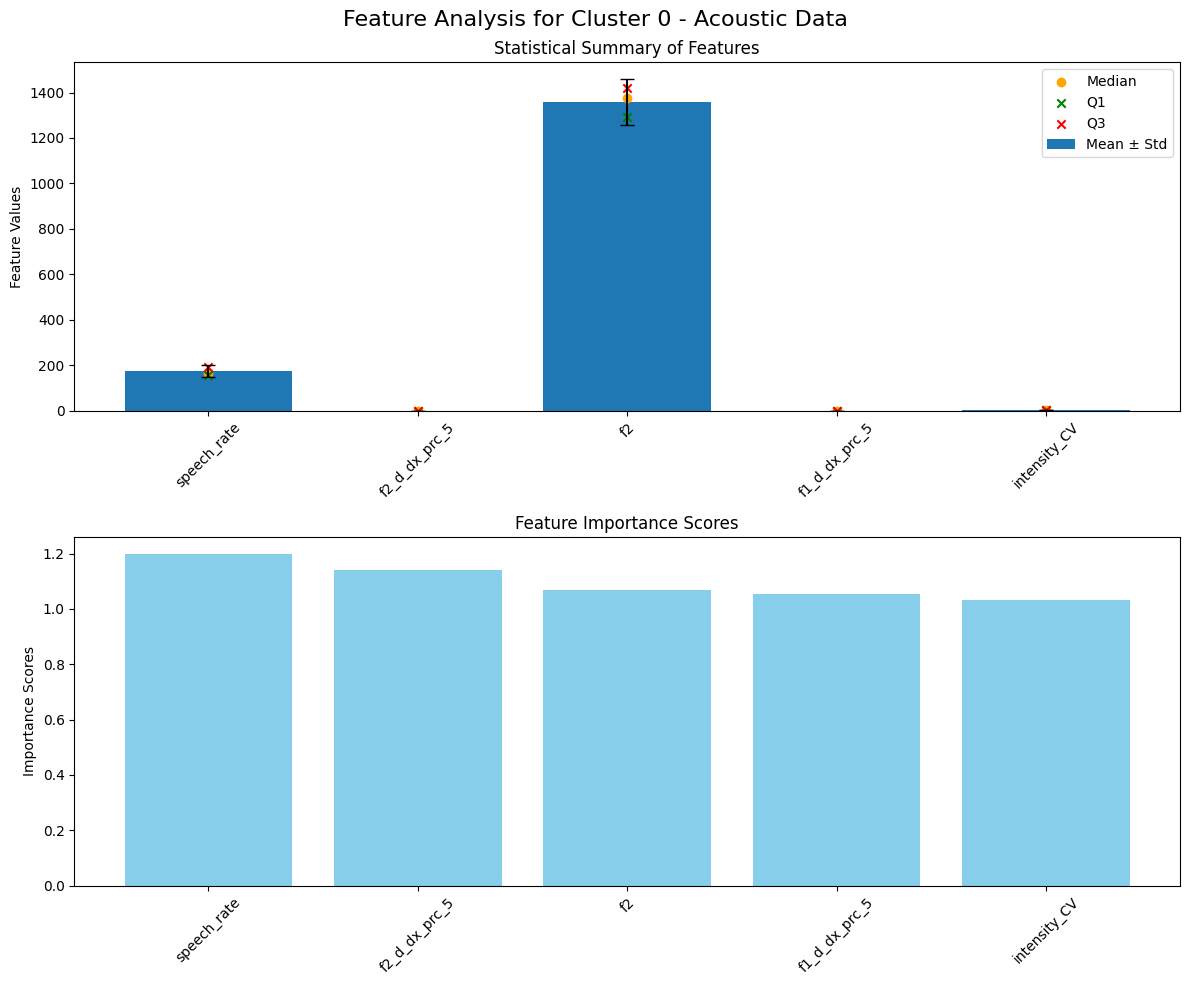

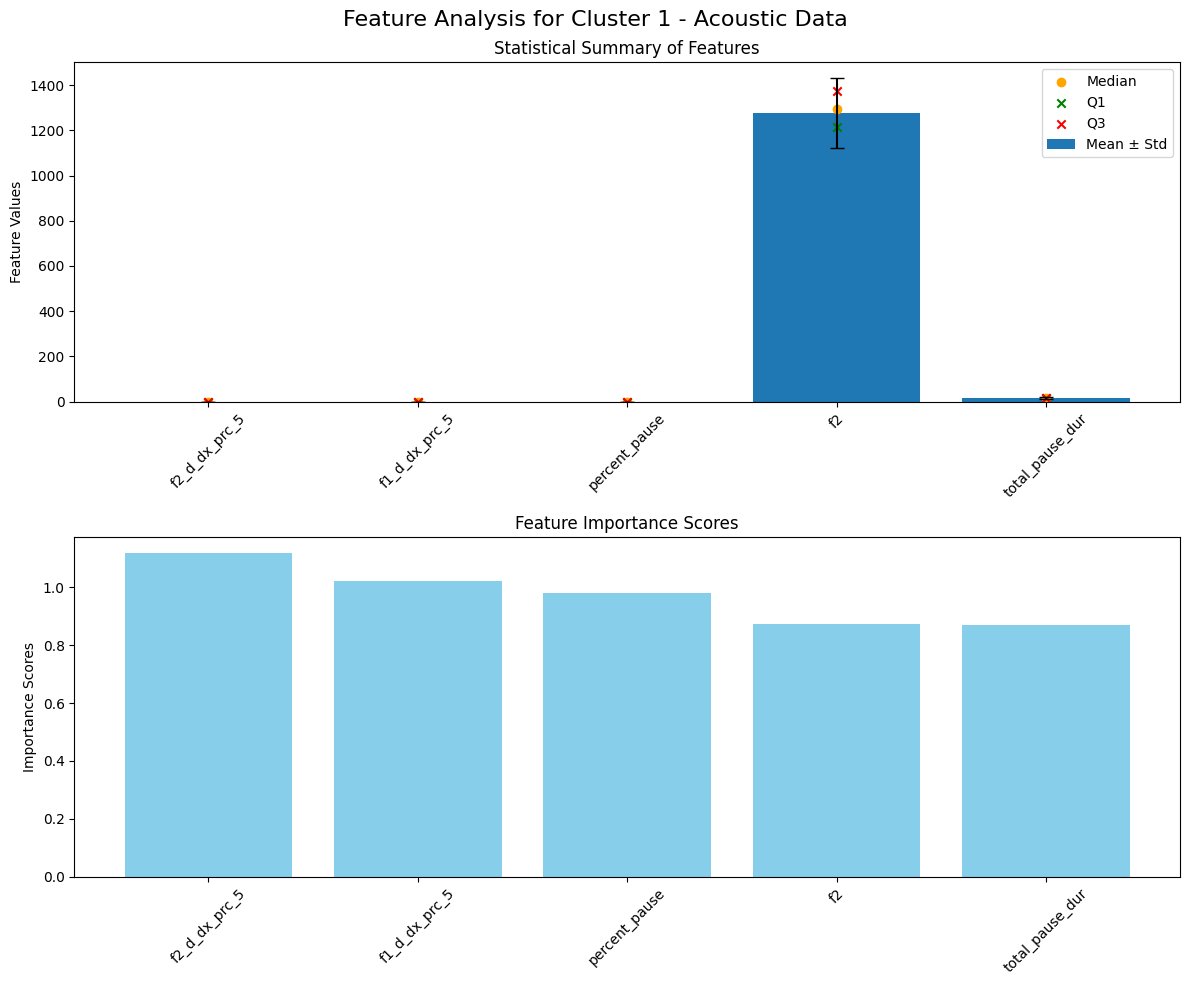

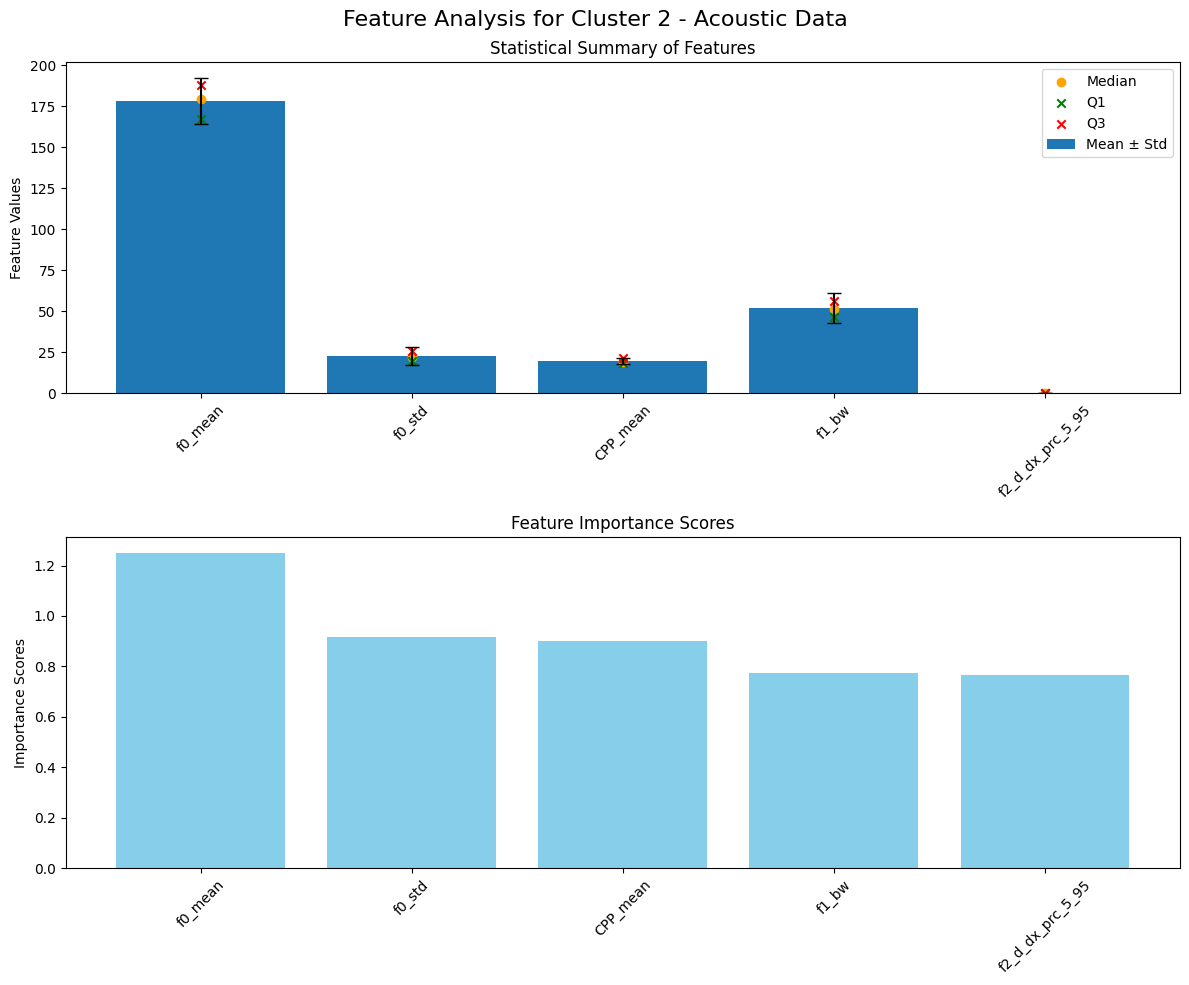

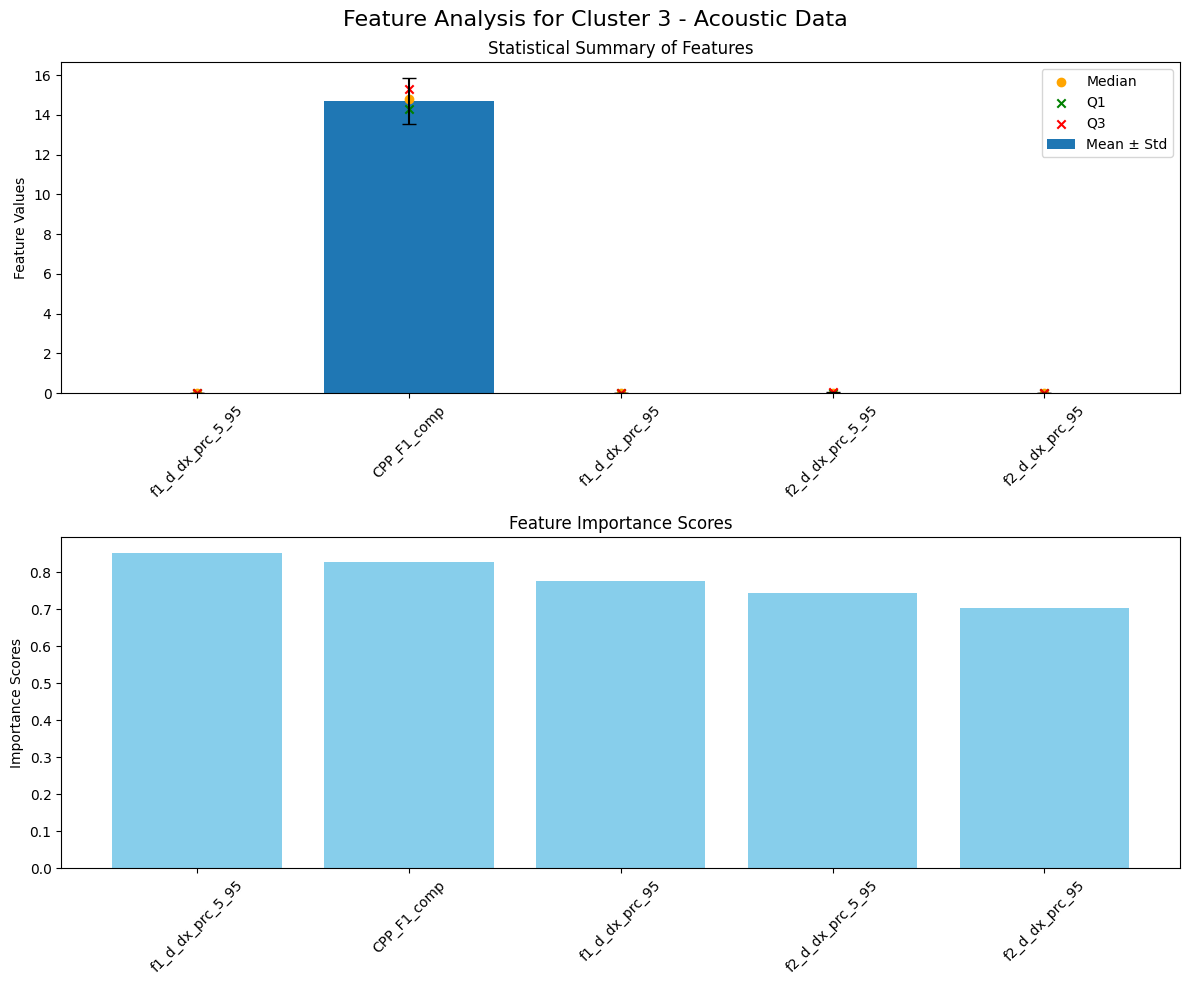


Top features for perceptual data:


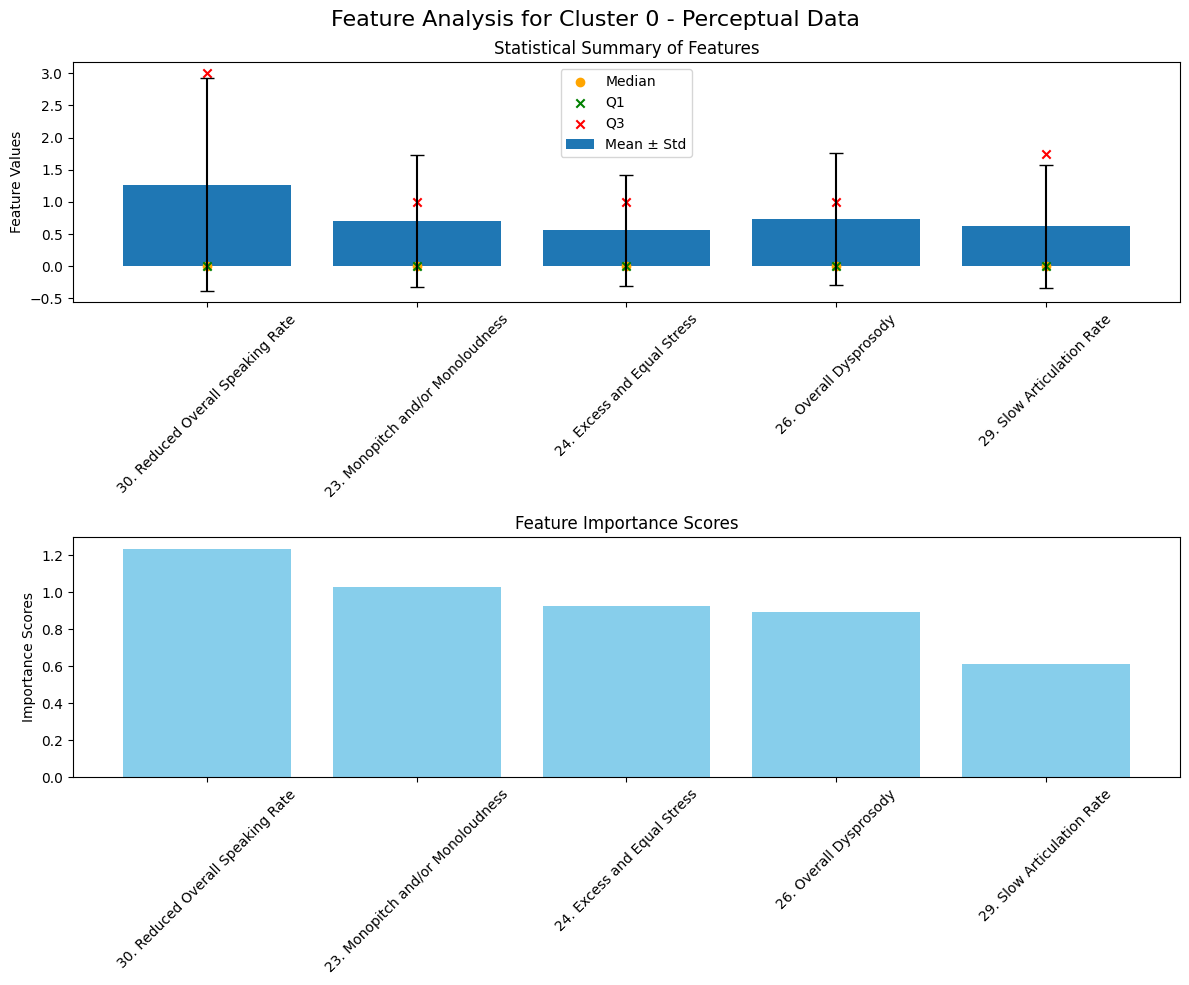

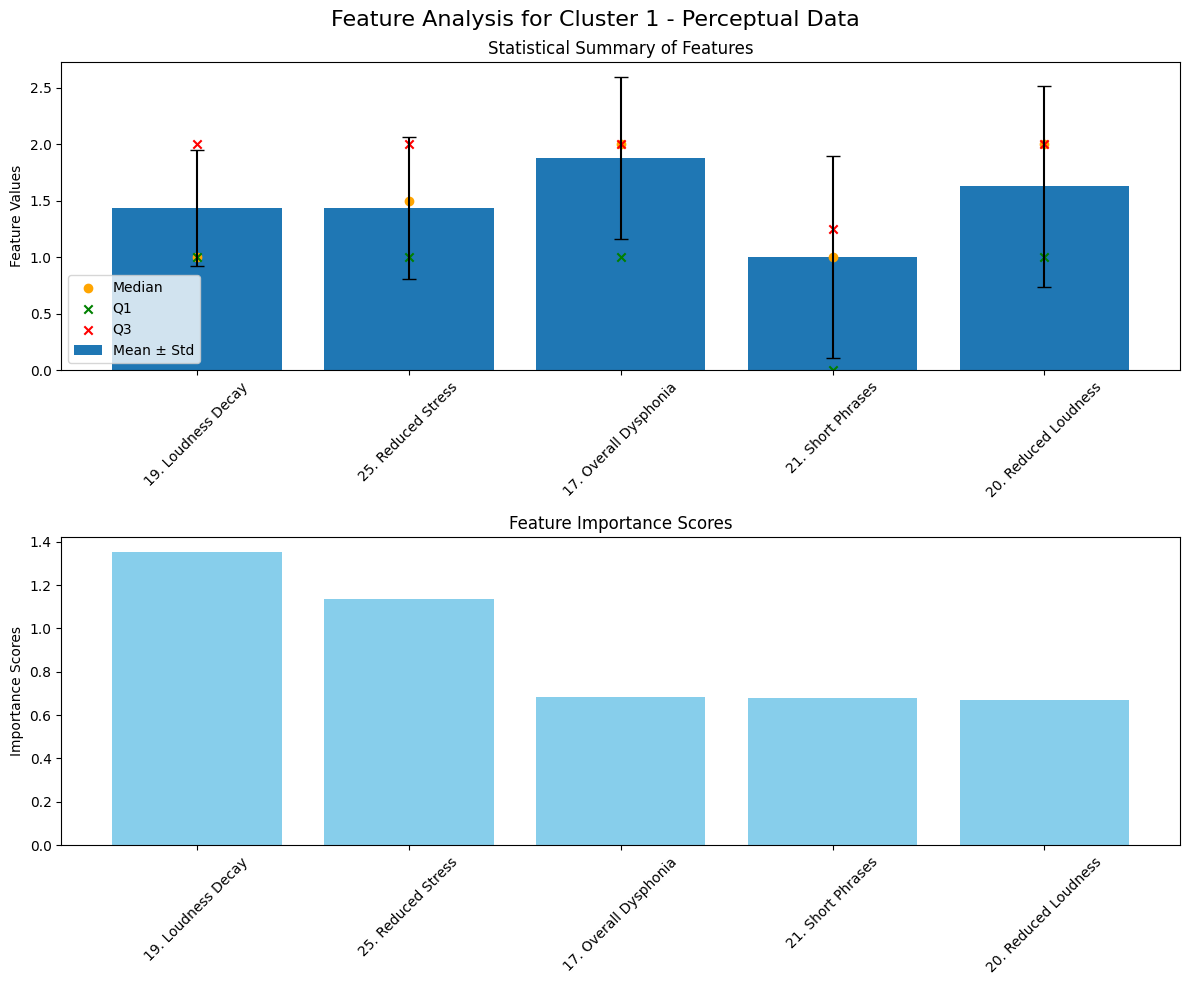

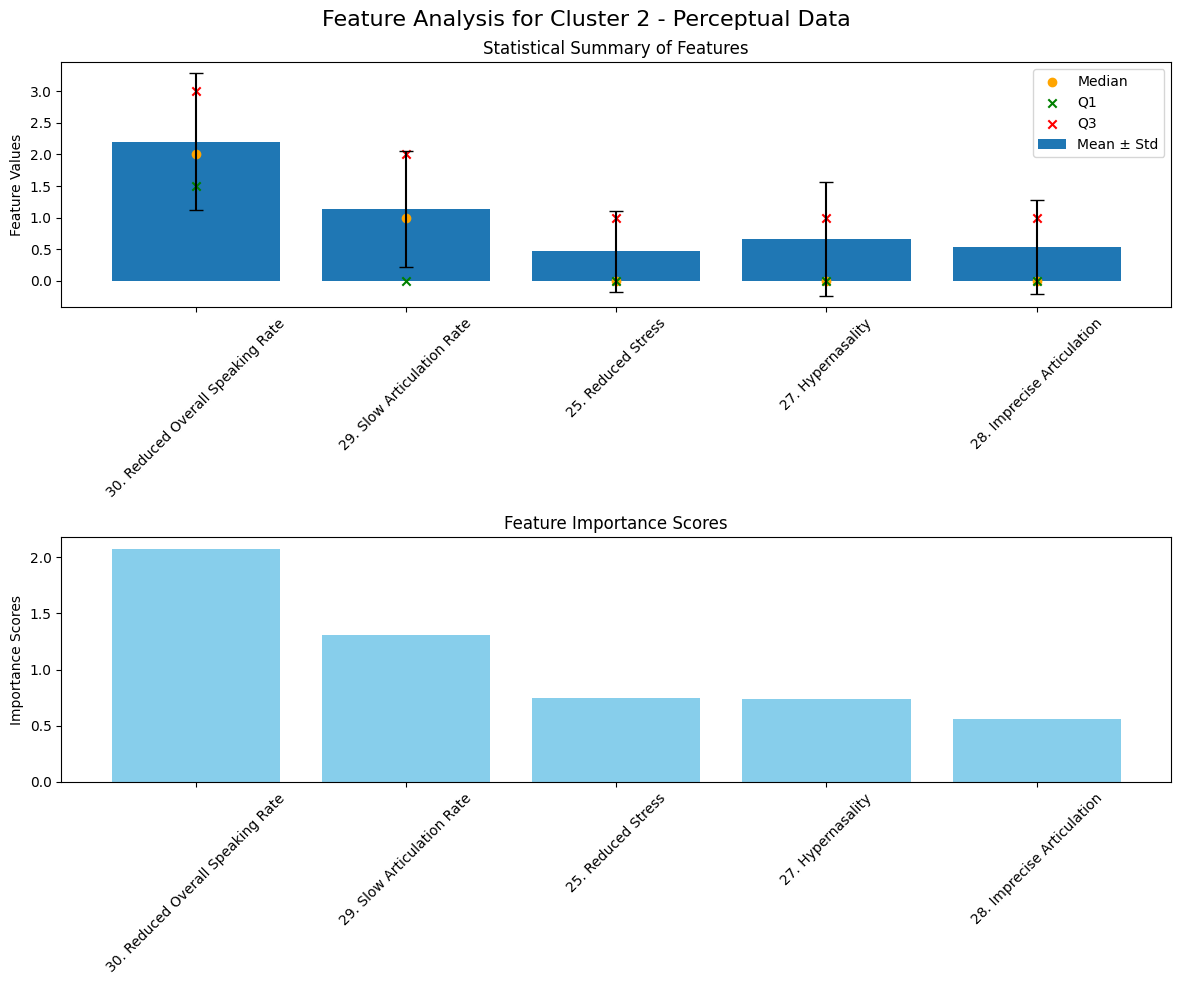

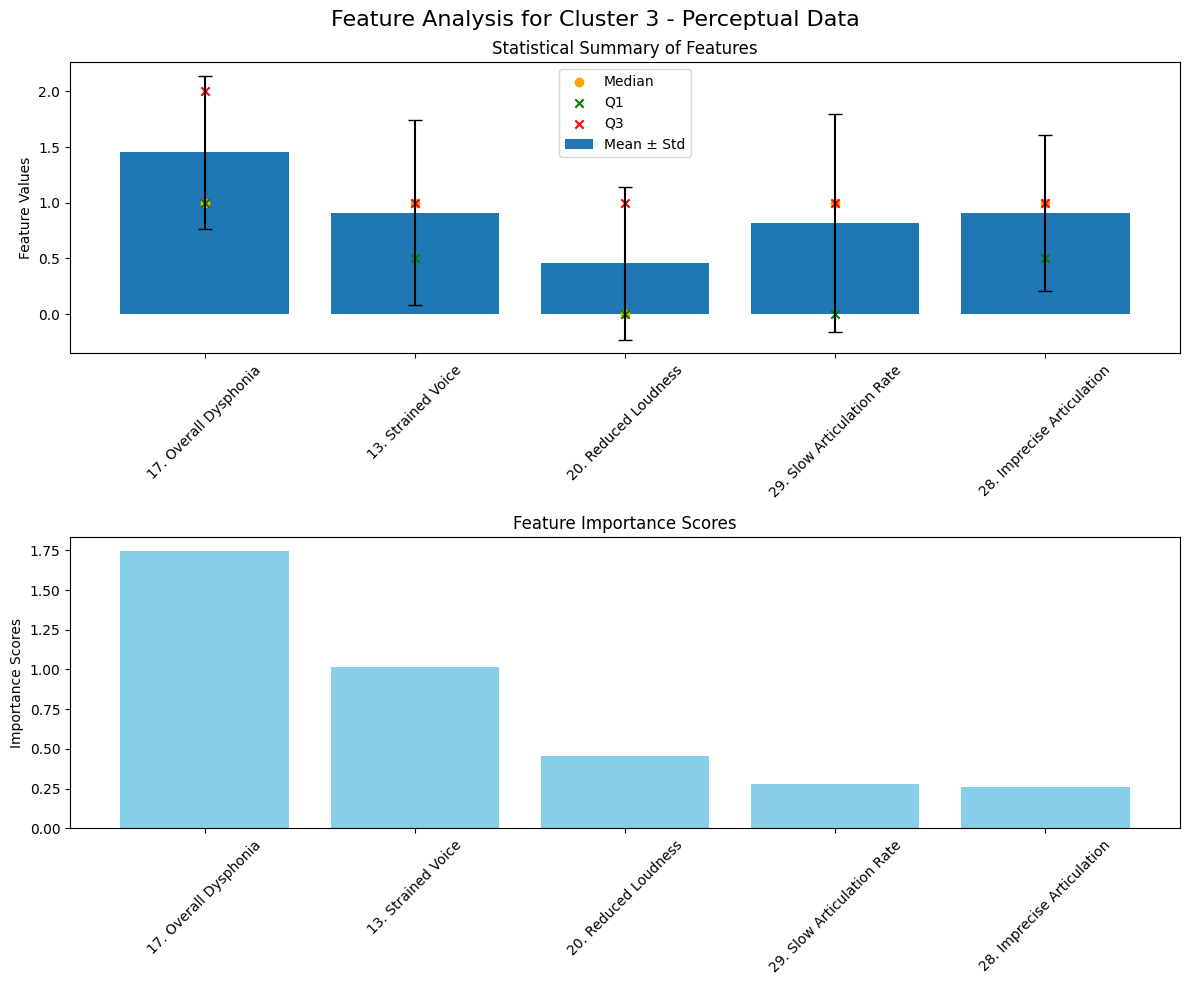

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Visualization function
def visualize_cluster_features(cluster_idx, feature_names, means, stds, medians, q1, q3, scores, data_type):
    # If perceptual, remove everything after "("
    if data_type == "perceptual":
        feature_names = [re.sub(r"\(.*\)", "", feat).strip() for feat in feature_names]

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f"Feature Analysis for Cluster {cluster_idx} - {data_type.capitalize()} Data", fontsize=16)

    # Plot Mean, Std, Median, Q1, Q3
    axes[0].bar(feature_names, means, yerr=stds, capsize=5, label='Mean ± Std')
    axes[0].scatter(feature_names, medians, color='orange', label='Median')
    axes[0].scatter(feature_names, q1, color='green', marker='x', label='Q1')
    axes[0].scatter(feature_names, q3, color='red', marker='x', label='Q3')
    axes[0].set_ylabel("Feature Values")
    axes[0].legend()
    axes[0].set_title("Statistical Summary of Features")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot Importance Scores
    axes[1].bar(feature_names, scores, color='skyblue')
    axes[1].set_ylabel("Importance Scores")
    axes[1].set_title("Feature Importance Scores")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Main Loop
for type in ["acoustic", "perceptual"]:
    top_features = top_feats[type]
    print(f"\nTop features for {type} data:")
    if type == "acoustic":
        columns = all_data.columns[first_acoustic:]
    elif type == "perceptual":
        columns = all_data.columns[:first_acoustic]
    
    temp_data = pd.DataFrame(all_data)[columns]
    for cluster_idx, features in top_features.items():
        # Get the features for the current cluster
        feature_names = features["Feature Names"]
        feature_scores = features["Scores"]

        # Get the mean and std of each feature for the current cluster
        means = temp_data.loc[catted[type] == cluster_idx, feature_names].mean()
        stds = temp_data.loc[catted[type] == cluster_idx, feature_names].std()
        medians = temp_data.loc[catted[type] == cluster_idx, feature_names].median()
        q1 = temp_data.loc[catted[type] == cluster_idx, feature_names].quantile(0.25)
        q3 = temp_data.loc[catted[type] == cluster_idx, feature_names].quantile(0.75)

        # Call the visualization function
        visualize_cluster_features(
            cluster_idx=cluster_idx,
            feature_names=feature_names,
            means=means,
            stds=stds,
            medians=medians,
            q1=q1,
            q3=q3,
            scores=feature_scores,
            data_type=type
        )
